In [2]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193673 sha256=045e192be99ab7460f4ae1fd51a68aa964988625301a23c74088e4c891995140
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from surprise import KNNWithMeans, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split

In [4]:
df_movies = pd.read_csv("/content/sample_data/movies.csv")
#df_ratings = pd.read_csv("Data/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings = pd.read_csv("/content/sample_data/ratings.csv")
#df_ratings = pd.read_csv("Data/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
df_ratings.drop(columns='timestamp', inplace=True)

In [7]:
df_cleaned = df_movies.merge(df_ratings, on='movieId')

In [8]:
df_cleaned.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [9]:
df_clean = df_cleaned[['userId','title','rating']]

In [10]:
df_clean.head()

,userId,title,rating
0,1,Toy Story (1995),4.0
1,5,Toy Story (1995),4.0
2,7,Toy Story (1995),4.5
3,15,Toy Story (1995),2.5
4,17,Toy Story (1995),4.5


In [33]:
num_users = len(df_clean['userId'].value_counts())
num_items = len(df_clean['title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of users in the dataset: 610
Unique number of movies in the dataset: 9719
Unique number of ratings in the dataset: 10


In [12]:
rating_count_df = pd.DataFrame(df_clean.groupby(['rating']).size(), columns=['Num Ratings'])
rating_count_df

,Num Ratings
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [34]:
rating_count_df = pd.DataFrame(df_clean.groupby(['rating']).size(), columns=['Num Ratings'])
total_ratings = rating_count_df['Num Ratings'].sum()
print(f"Total number of ratings: {total_ratings}")

Total number of ratings: 100836


In [36]:
# Group the data by user_id and rating and count the number of ratings for each user
user_rating_count = df_clean.groupby(['userId', 'rating']).size().reset_index(name='count')

# Group the data by user_id and sum the number of ratings for each user
user_total_ratings = user_rating_count.groupby(['userId'])['count'].sum().reset_index(name='total_count')

# Sort the resulting DataFrame in descending order and select the top 5 rows
top_users = user_total_ratings.sort_values(by='total_count', ascending=False)[:5]

# Calculate the total number of ratings
total_ratings = user_total_ratings['total_count'].sum()

# Print the top 5 users and the percentage of total ratings for each user
print("Top 5 users with the most ratings:")
for _, row in top_users.iterrows():
    user_id = row['userId']
    num_ratings = row['total_count']
    percent = num_ratings / total_ratings * 100
    print(f"User {user_id}: {num_ratings} ratings ({percent:.2f}%)")

Top 5 users with the most ratings:
User 414: 2698 ratings (2.68%)
User 599: 2478 ratings (2.46%)
User 474: 2108 ratings (2.09%)
User 448: 1864 ratings (1.85%)
User 274: 1346 ratings (1.33%)


In [13]:
#########################

PLOTS BELOW

Text(0, 0.5, 'Number of Ratings')

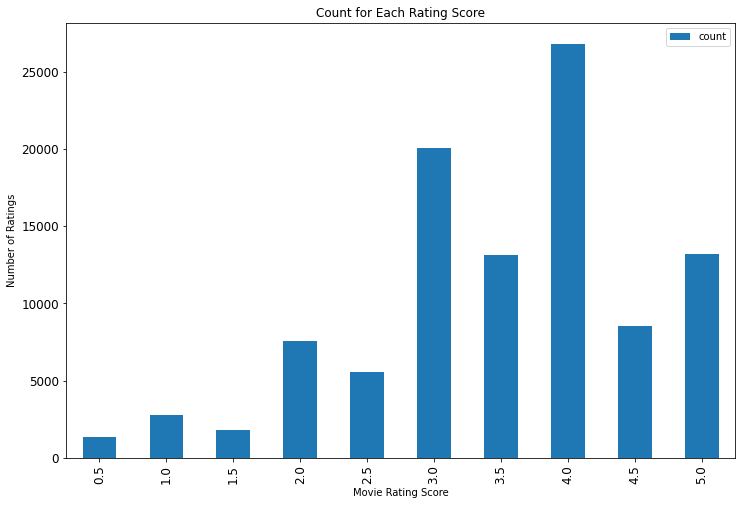

In [14]:
rtg_countdf = pd.DataFrame(df_clean.groupby(['rating']).size(), columns=['count'])

ax = rtg_countdf.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("Movie Rating Score")
ax.set_ylabel("Number of Ratings")

PLOTS ABOVE

In [15]:
import surprise
from surprise import Dataset, Reader, SVD
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
# Load the dataset using Surprise
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df_clean[['userId', 'title', 'rating']], reader)

In [17]:
train, test = train_test_split(data, test_size=0.2, random_state=42)


In [20]:
from surprise import SVD

svd = SVD()

trainset = data.build_full_trainset()
svd.fit(trainset)

In [21]:
#algo.test(test)

In [25]:
surprise.accuracy.mae(svd.test(test))

MAE:  0.4936


0.49362962884046496

In [26]:
surprise.accuracy.rmse(svd.test(test))

RMSE: 0.6358


0.6357627303289126

In [39]:
# Choose a user for whom to make recommendations
user_id = 414

# Get the list of all movies in the dataset
all_movies = df_clean['title'].unique()

# Get the list of movies that the user has already rated
user_rated_movies = df_clean[df_clean['userId'] == user_id]['title'].unique()

# Create a list of tuples containing each movie and its predicted rating for the user
movie_ratings = [(movie_title, svd.predict(user_id, movie_id).est) for movie_id, movie_title in enumerate(all_movies) if movie_title not in user_rated_movies]

# Sort the list of tuples in descending order of predicted rating
movie_ratings.sort(key=lambda x: x[1], reverse=True)

# Return the top 5 movies from the sorted list
top_movies = [movie_title for movie_title, _ in movie_ratings[:5]]
print(top_movies)

['Waiting to Exhale (1995)', 'Sudden Death (1995)', 'Dracula: Dead and Loving It (1995)', 'Balto (1995)', 'Nixon (1995)']
